In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

from os import path
import sys
sys.path.append(path.abspath('..'))

In [49]:
import os
import cv2 
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from configs.config import Config
from src.training_module import AmazonForestClassifier
from src.augmentations import get_valid_transforms

In [7]:
DEVICE = 'cuda:0'

In [9]:
checkpoint_name = '../weights/best_model.ckpt'
state_dict = torch.load(checkpoint_name)['state_dict']

config_name = '../configs/config.yaml'
config = Config.from_yaml(config_name)
module = AmazonForestClassifier(config)

module.load_state_dict(state_dict)
_ = module.eval()
_ = module.to(DEVICE)

<All keys matched successfully>

In [16]:
DATA_FOLDER = '../data/'

df = pd.read_csv(
    os.path.join(DATA_FOLDER, 'test_df.csv')
)

image_names = df['image_name'].to_list()
print('Total images:', len(image_names))
df.head(10)

Total images: 4027


,image_name,haze,blow_down,partly_cloudy,water,conventional_mine,selective_logging,habitation,clear,road,cultivation,artisinal_mine,primary,blooming,cloudy,slash_burn,agriculture,bare_ground
0,train_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,train_7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,train_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,train_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,train_21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,train_24,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,train_26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,train_28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,train_29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,train_32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [17]:
img_height, img_width = 256, 256
preprocess = get_valid_transforms(img_width, img_height)

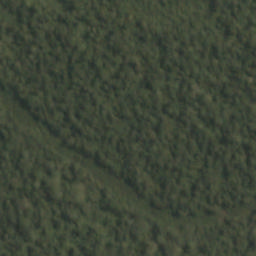

In [106]:
idx = 3732
image_path = os.path.join(DATA_FOLDER, f'train-jpg/{image_names[idx]}.jpg')
image = cv2.imread(image_path)[..., ::-1]
Image.fromarray(image)

In [107]:
precessed_image = preprocess(image=image)['image']
with torch.no_grad():
    scores = torch.sigmoid(
        module(
            precessed_image[None].to(DEVICE)
        )
    )[0].cpu().numpy()

In [108]:
labels = df.drop('image_name',axis=1).columns.values
true_scores = df[df['image_name'] == image_names[idx]]
true_scores = true_scores.drop('image_name', axis=1).values[0]

scores = [1 if score > 0.5 else 0 for score in scores]
print(scores)
print(true_scores)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


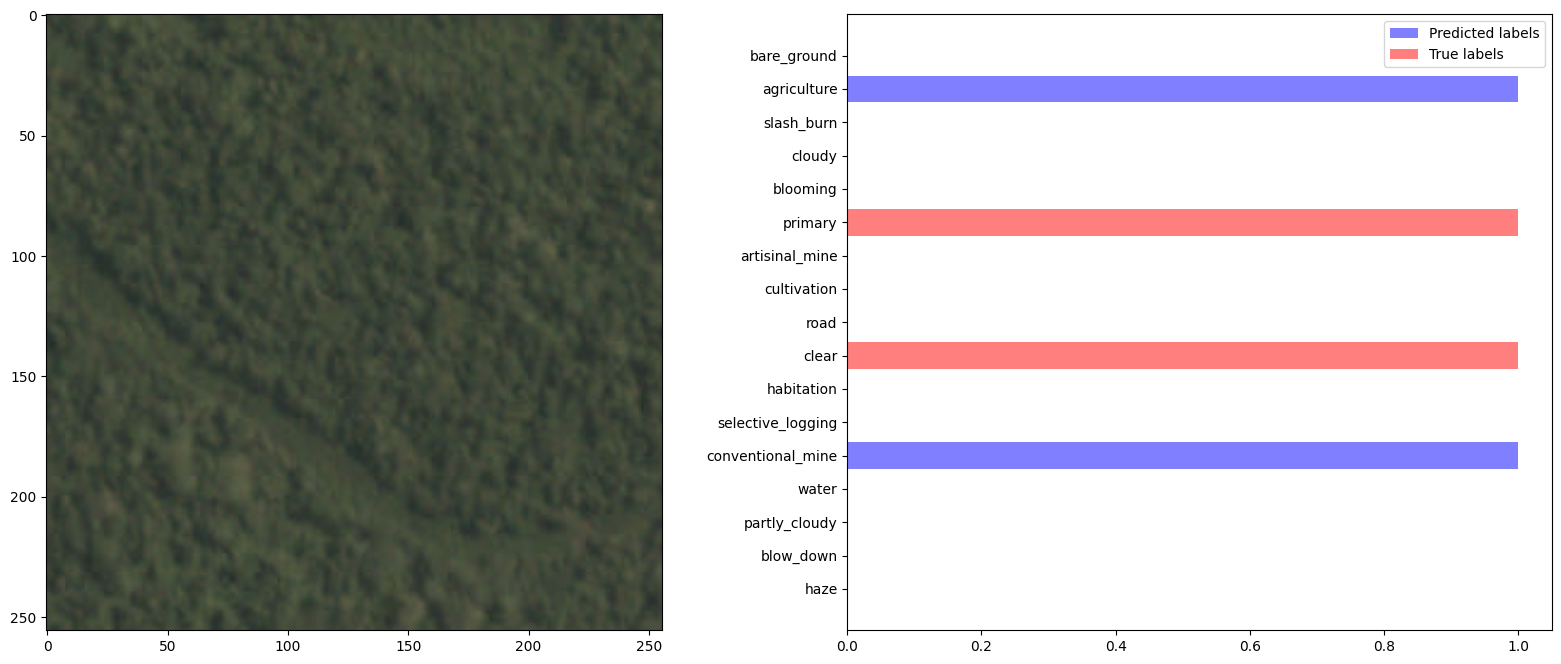

In [109]:

_, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].imshow(image)
ps = ax[1].barh(labels, scores, color='blue', label='Predicted labels', alpha=0.5)
ts = ax[1].barh(labels, true_scores, color='red', label='True labels', alpha=0.5)
ax[1].legend(handles=[ps, ts])
plt.show()